# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import skimage.io

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Amine OULD KACI\anaconda3\envs\mrc

## Configurations

In [2]:
class ViolinConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "violin"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256 #changed
    IMAGE_MAX_DIM = 256 # changed

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 50 ## changed

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 168/IMAGES_PER_GPU

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = ViolinConfig()
config.display()

import warnings
import re

warnings.filterwarnings('ignore', category=FutureWarning, message=re.escape("Input image dtype is bool. Interpolation is not defined with bool data type."))



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ViolinDataset(utils.Dataset):
    def load_violins(self, dataset_dir, json_path):
        # Ajouter la classe
        self.add_class("violin", 1, "violin")  # 1 est l'ID de la classe "violon"

        # Charger les annotations depuis le fichier JSON
        with open(json_path) as f:
            annotations = json.load(f)
        #print(annotations)
        # Parcourir les annotations pour ajouter les images
        for annotation in annotations:
            #filename = annotation['filename']
            filename = annotations[annotation]['filename']
            #width = annotations[annotation]['width']
            #height = annotations[annotation]['height']
            size = annotations[annotation]['size']
            polygons = annotations[annotation]['regions']  # Cela peut être des masques ou des boîtes englobantes

            image_path = os.path.join(dataset_dir, filename)
            self.add_image(
                "violin",
                image_id=filename,
                path=image_path,
                size=size,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """
        Charge les masques de segmentation pour une image donnée.
        Chaque objet est représenté par un polygone (polyline).
        """
        # Obtenir les informations de l'image à partir de image_id
        info = self.image_info[image_id]
        
        # Charger l'image pour obtenir sa taille
        image = self.load_image(image_id)
        height, width = image.shape[:2]
        
        # Initialiser un masque vide de taille (hauteur, largeur, nombre de polygones)
        mask = np.zeros((height, width, len(info['polygons'])), dtype=np.uint8)
        # Liste des ID de classes pour les objets
        class_ids = []
        # Parcourir les régions annotées (polygones)
        for i, region in enumerate(info['polygons']):
            
            # Extraire les coordonnées du polygone
            shape_attr = region['shape_attributes']
            all_points_x = shape_attr['all_points_x']
            all_points_y = shape_attr['all_points_y']
            # Convertir les coordonnées du polygone en indices de pixels
            poly_x, poly_y = skimage.draw.polygon(all_points_y, all_points_x)
            
            # Assurer que les indices sont dans les limites de l'image
            poly_x = np.clip(poly_x, 0, height - 1)
            poly_y = np.clip(poly_y, 0, width - 1)
            # Remplir le masque pour cette instance de polygone
            mask[poly_x, poly_y, i] = 1
            # Ajouter l'ID de la classe (par exemple, "violin")
            class_ids.append(self.class_names.index(region['region_attributes']['type']))

        # Retourner le masque et les ID des classes
        return mask, np.array(class_ids)

In [5]:
# Créez une instance de votre dataset et chargez les données
dataset = ViolinDataset()
dataset.load_violins("./train", "./train/via_project_3Nov2024_17h58m_json.json")
dataset.prepare()

# Parcourez quelques images pour tester
for image_id in range(min(5, len(dataset.image_info))):  # Affiche les 5 premières images
    # Charger l'image et le masque
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

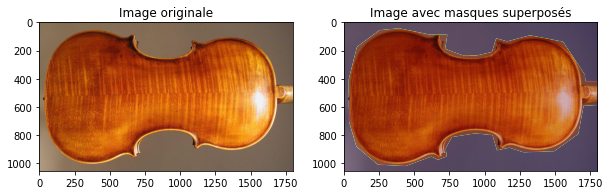

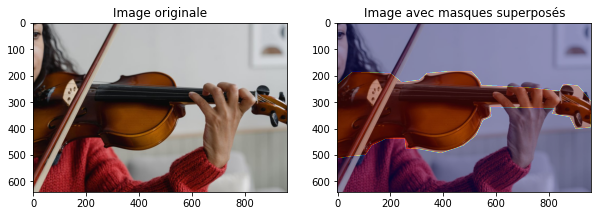

In [6]:
import matplotlib.pyplot as plt


# Créez une instance de votre dataset et chargez les données
dataset = ViolinDataset()
dataset.load_violins("./train", "./train/via_project_3Nov2024_17h58m_json.json")
dataset.prepare()

# Parcourez quelques images pour tester
for image_id in range(min(2, len(dataset.image_info))):  # Affiche les 5 premières images
    # Charger l'image et le masque
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Afficher l'image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image originale")
    
    # Superposer le masque sur l'image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for i in range(mask.shape[-1]):
        plt.imshow(mask[:, :, i], alpha=0.3, cmap="jet")  # Affiche chaque masque avec une transparence

    plt.title("Image avec masques superposés")
    plt.show()


In [7]:
# Training dataset
dataset_train = ViolinDataset()
dataset_train.load_violins('./train', './train/via_project_3Nov2024_17h58m_json.json')
dataset_train.prepare()

# Validation dataset
dataset_val = ViolinDataset()
dataset_val.load_violins('./test', './test/via_project_8Nov2024_22h27m_json.json')
dataset_val.prepare()

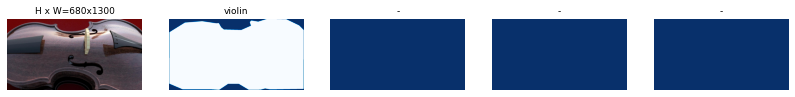

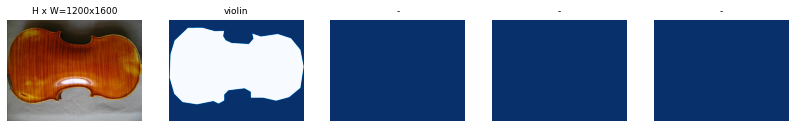

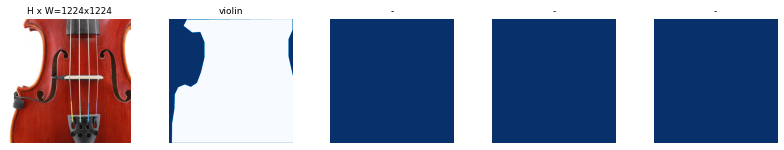

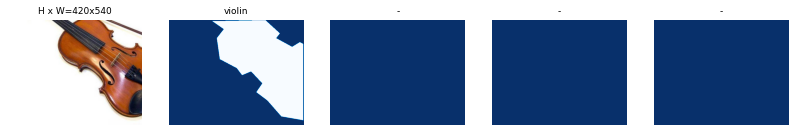

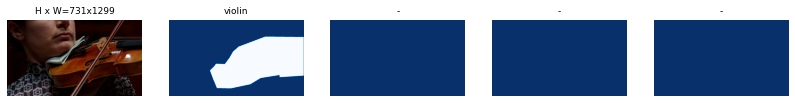

In [8]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)  # Assuming this returns class_ids along with the mask
    print(dataset_train)
    
    # Pass the mask and corresponding class_ids to visualize.display_top_masks
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\Amine OULD KACI\Documents\mrcnn\logs\violin20241110T0830\mask_rcnn_violin_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Amine OULD KACI\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/30
21/21 [==============================] - 884s 42s/step - loss: 2.4007 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8528 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.7626 - mrcnn_mask_loss: 0.6027 - val_loss: 1.8437 - val_rpn_class_loss: 0.0384 - val_rpn_bbox_loss: 0.9224 - val_mrcnn_class_loss: 0.0824 - val_mrcnn_bbox_loss: 0.5031 - val_mrcnn_mask_loss: 0.2973
Epoch 2/30
21/21 [==============================] - 908s 43s/step - loss: 1.1497 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2361 - val_loss: 1.5819 - val_rpn_class_loss: 0.0281 - val_rpn_bbox_loss: 0.7824 - val_mrcnn_class_loss: 0.0837 - val_mrcnn_bbox_loss: 0.4060 - val_mrcnn_mask_loss: 0.2819
Epoch 3/30
21/21 [==============================] - 911s 43s/step - loss: 0.8770 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2143 - val_loss: 1.5805 - val_rpn_class_lo

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#model.train(dataset_train, dataset_val, 
 #           learning_rate=config.LEARNING_RATE / 10,
  #          epochs=5, 
   #         layers="all")

In [13]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [86]:
class InferenceConfig(ViolinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  c:\Users\Amine OULD KACI\Documents\mrcnn\logs\violin20241110T0830\mask_rcnn_violin_0030.h5
Re-starting from epoch 30


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  885.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   50.00000  max:  222.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8


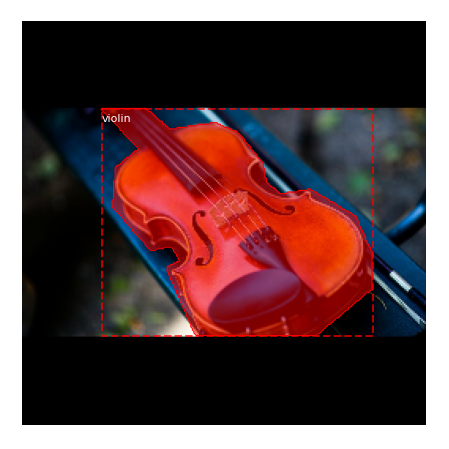

In [111]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


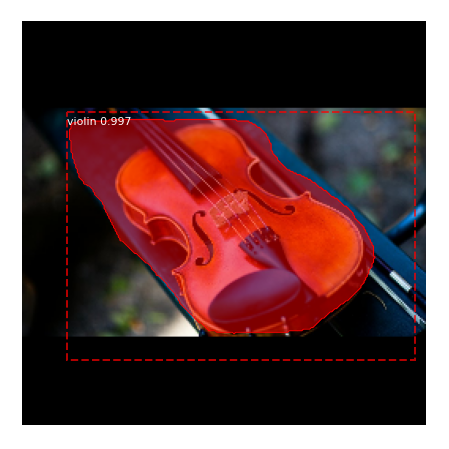

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (410, 537, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  537.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


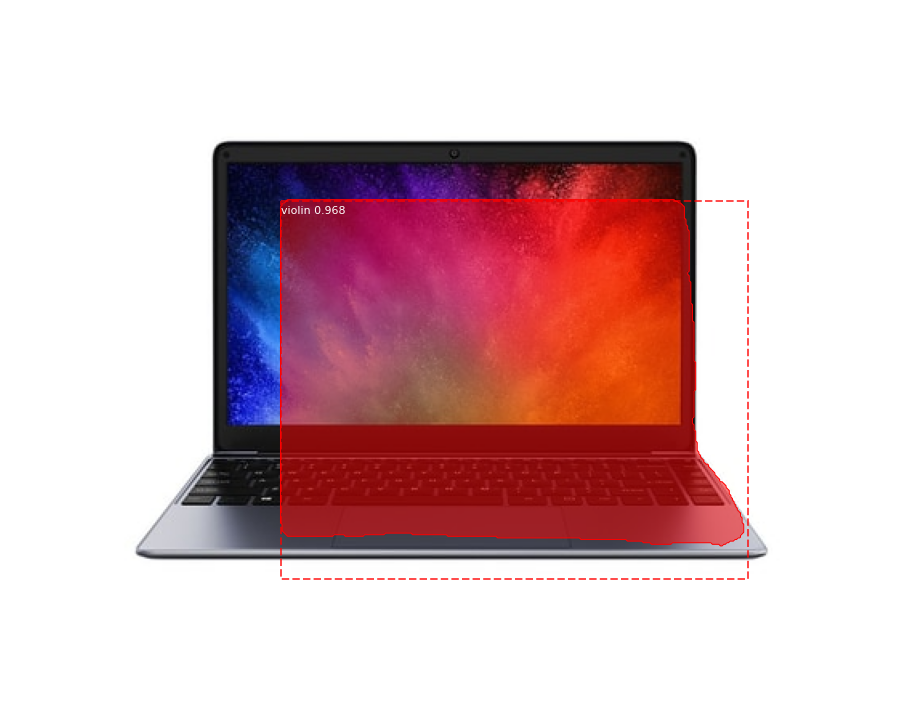

In [126]:
# Charger votre image
image_path = "./test/40.jpg"  # Remplacez par le chemin de votre image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Effectuer la détection
results = model.detect([image], verbose=1)
r = results[0]

# Visualiser les résultats
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["BG", "violin"], r['scores'])

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on all validation images
image_ids = dataset_val.image_ids
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    
    # Skip images without ground truth objects (e.g., no violins)
    if len(gt_class_id) == 0:
        continue  # Skip this image and move to the next one

    # Preprocess the image for the model
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = \
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    
    APs.append(AP)

# Compute the mean Average Precision (mAP)
if len(APs) > 0:
    mean_AP = np.mean(APs)
    print("mAP: ", mean_AP)
else:
    print("No valid images with ground truth objects to calculate mAP.")


Processing 1 images
image                    shape: (1601, 1601, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1601.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


ValueError: shapes (1,2563201) and (65536,1) not aligned: 2563201 (dim 1) != 65536 (dim 0)